In [2]:
import kagglehub # might need to pip install kagglehub
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, max, min, countDistinct, sum, round
import geopandas as gpd
import plotly.express as px


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# don't run this part still working on it

In [3]:
# Don't 

# Download the dataset to the current directory
try:
    # Replace with the correct dataset identifier
    path = kagglehub.dataset_download("erdi28/zip-codes-demographics")
    print(f"Dataset downloaded to: {path}")

    # Save the dataset as a CSV file in the current directory
    for file_name in os.listdir(path):
        if file_name.endswith(".csv"):
            shutil.move(os.path.join(path, file_name), os.getcwd())
            print(f"CSV file saved to: {os.path.join(os.getcwd(), file_name)}")
except AttributeError as e:
    print("Error: The kagglehub module does not support the method used.")
    print("Please check the documentation or update the library.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset downloaded to: /Users/kunle/.cache/kagglehub/datasets/erdi28/zip-codes-demographics/versions/3


In [4]:
## Set up PySpark environment
from pyspark.sql import SparkSession

In [5]:
## Initialize the SparkSession
# appName is the name of the application
# getOrCreate() creates a new session or retrieves an existing one
spark = SparkSession.builder \
    .appName("ZipCode PySpark Learning") \
        .getOrCreate()

## Verify that SparkSession is created
spark

25/04/19 18:28:39 WARN Utils: Your hostname, Zipcoders-MacBook-Pro-5.local resolves to a loopback address: 127.0.0.1; using 192.168.3.155 instead (on interface en0)
25/04/19 18:28:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 18:28:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/19 18:28:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
try:
    zip_df = spark.read.csv ('./data/zip_code_demographics.csv', header=True, inferSchema=True)
    print('Data loaded successfully')
except Exception as e:
    print(f'Error loading data: {e}')

Data loaded successfully


In [7]:
zip_df.show(10)

+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
| zip|     lat|      lng|        city|state_id|   state_name|population|density|county_name|po_box|      dist_highway|dist2_large_airport|dist2_medium_airport|   dist_to_shore|number_of_business|adjusted_gross_income|total_income_amount|number_of_returns|
+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
|1001|42.06262|-72.62521|      Agawam|      MA|Massachusetts|     16088|  550.1|    Hampden|     0|  1.38703489958776|   106.145765467407|    12.9462123500772|93.0492507357679|               438|               598807|           6047

In [8]:
zip_df.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_name: string (nullable = true)
 |-- po_box: integer (nullable = true)
 |-- dist_highway: double (nullable = true)
 |-- dist2_large_airport: double (nullable = true)
 |-- dist2_medium_airport: double (nullable = true)
 |-- dist_to_shore: double (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- number_of_returns: integer (nullable = true)



## Pop by State -> in state pop by zip

In [ ]:
# filtering the data needed for analysis
zip_pop_df = zip_df.select('state_id','state_name','population').groupBy('state_id','state_name').agg(sum('population').alias("total_population"))
zip_pop_df.show(10)

+--------+--------------------+----------------+
|state_id|          state_name|total_population|
+--------+--------------------+----------------+
|      MT|             Montana|         1511394|
|      NC|      North Carolina|        12419438|
|      MD|            Maryland|         7224056|
|      CO|            Colorado|         6617159|
|      CT|         Connecticut|         3819343|
|      IL|            Illinois|        13819331|
|      WY|             Wyoming|         1182453|
|      NJ|          New Jersey|         9823423|
|      DE|            Delaware|         1372445|
|      DC|District of Columbia|         1207283|
+--------+--------------------+----------------+
only showing top 10 rows



In [10]:
zip_pop_df.orderBy(col("total_population").desc()).show(5)

+--------+------------+----------------+
|state_id|  state_name|total_population|
+--------+------------+----------------+
|      CA|  California|        44183935|
|      TX|       Texas|        33411444|
|      NY|    New York|        23903874|
|      FL|     Florida|        23007226|
|      PA|Pennsylvania|        16557706|
+--------+------------+----------------+
only showing top 5 rows



Making US Heat map

In [ ]:
# convert to pandas for plotting
zip_pop_pd = zip_pop_df.toPandas()

In [ ]:
# getting shape data, downloaded from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
shape_path = './data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
shape = gpd.read_file(shape_path)
print(shape.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [ ]:
# left join the dataframes
shape_for_graph = pd.merge(
    left = shape,
    right = zip_pop_pd,
    left_on = 'NAME',
    right_on ='state_name',
    how = 'left'
)

In [29]:
# making sure the merge worked
shape_for_graph.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'state_id', 'state_name',
       'total_population'],
      dtype='object')

In [30]:
# getiting rid of the null values
shape_for_graph = shape_for_graph.dropna()


In [ ]:
# elminating those states makes the graph look better
shape_for_graph = shape_for_graph[~shape_for_graph['NAME'].isin(['Alaska', 'Hawaii','Puerto Rico'])]

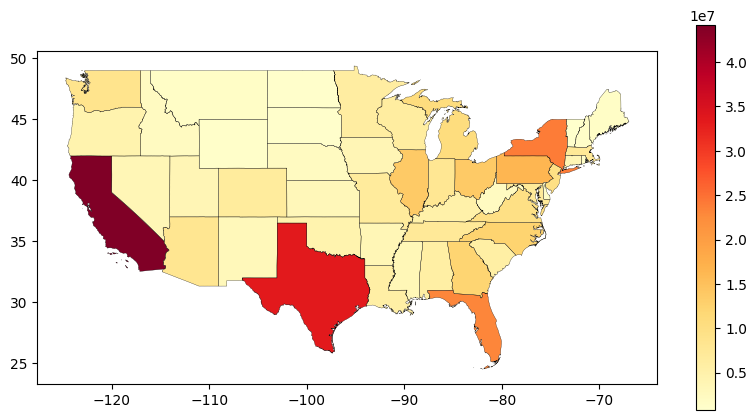

In [ ]:
# Plotting the data
ax = shape_for_graph.boundary.plot(edgecolor ='black', linewidth=0.2, figsize=(10,5))
shape_for_graph.plot(ax=ax, column="total_population", legend=True, cmap='YlOrRd')
plt.show()

## Population by Zip Code of most Populated State, California

In [23]:
# Collecting data for California
ca_zip_df = zip_df.select('zip','state_id', 'state_name', 'population') \
    .where(zip_df.state_id == 'CA') \
        .orderBy(col('population').desc())

ca_zip_df.show(10)

+-----+--------+----------+----------+
|  zip|state_id|state_name|population|
+-----+--------+----------+----------+
|90011|      CA|California|    109511|
|90650|      CA|California|    103427|
|91331|      CA|California|    102553|
|94565|      CA|California|    100700|
|90044|      CA|California|    100225|
|92336|      CA|California|     98896|
|92335|      CA|California|     97358|
|90805|      CA|California|     96840|
|90250|      CA|California|     96730|
|90201|      CA|California|     96605|
+-----+--------+----------+----------+
only showing top 10 rows



Exploring the data

In [24]:
# using pandas to check the shape of the dataframe
# this is a workaround to check the shape of the dataframe
ca_zip_df.toPandas().shape


(1802, 4)

In [25]:
# wanted to check if I had any duplicates or need to aggregate zip codes
ca_zip_df.toPandas().nunique()

zip           1802
state_id         1
state_name       1
population    1447
dtype: int64

In [26]:
ca_zip_df_shorted = ca_zip_df.orderBy(col('population').desc())
# Select the top 2 rows
top_2 = ca_zip_df_shorted.limit(5)

# Select the bottom 2 rows
# where the population is greater than 0 to avoid empty rows
bottom_2 = ca_zip_df_shorted.where(col('population') > 0).orderBy(col('population').asc()).limit(5)

# Calculate the middle row index
total_rows = ca_zip_df_shorted.count()
middle_index = total_rows // 2

# Select the middle row(s)
# had to convert to pandas to use tail to get that last row
# because pyspark doesn't have a direct way to get the middle row
middle_rows = ca_zip_df_shorted.orderBy(col('population').desc()).limit(middle_index + 1).toPandas().tail(1)


ca_new = pd.concat([top_2.toPandas(), middle_rows, bottom_2.toPandas()], ignore_index=True)

ca_new

,zip,state_id,state_name,population
0,90011,CA,California,109511
1,90650,CA,California,103427
2,91331,CA,California,102553
3,94565,CA,California,100700
4,90044,CA,California,100225
5,94519,CA,California,20495
6,93621,CA,California,31
7,96071,CA,California,86
8,96040,CA,California,86
9,95375,CA,California,97


Make Pie Chart to look at population distribution

In [27]:
over_100k = ca_zip_df.filter(col('population') > 100000).count()
between_80k_100k = ca_zip_df.filter(col('population').between(80000, 100000)).count() # inclusive
between_50k_80k =  ca_zip_df.filter((col('population') > 50000) & (col('population') < 80000)).count()
between_20k_50k =  ca_zip_df.filter((col('population') > 20000) & (col('population') <= 50000)).count()
less_20k =  ca_zip_df.filter(col('population') <= 20000).count()
# Create a list of the counts
counts = [over_100k, between_80k_100k, between_50k_80k, between_20k_50k, less_20k]
# Create a list of the labels
labels = ['Over 100k', '80k-100k', '50k-80k', '20k-50k', 'Less than 20k']
# create a dataframe to plot
counts_df = pd.DataFrame({'Population Range': labels, 'Count': counts})

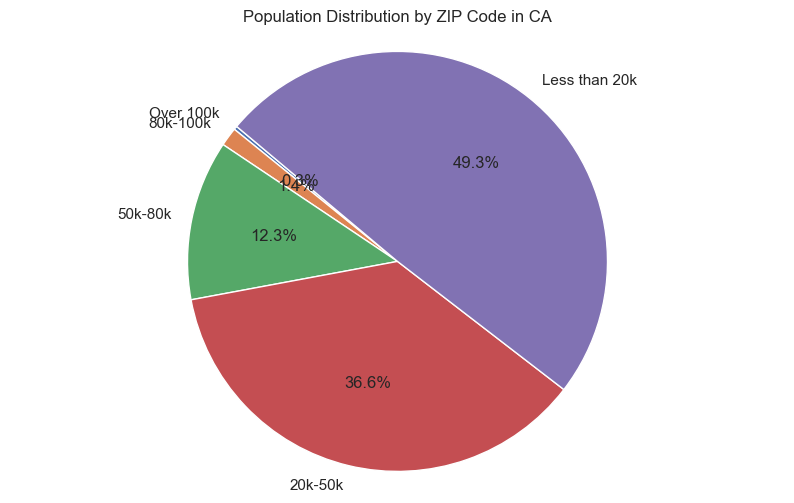

In [28]:
# Plotting the data using seaborn pie chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
# Create a pie chart
plt.pie(counts_df['Count'], labels=counts_df['Population Range'], autopct='%1.1f%%', startangle=140)
plt.title('Population Distribution by ZIP Code in CA')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## AGI by buisness by zip, AGI by total income by zip 

## AGI by shore

## airport shore nuber of business zipcode

## number of returns by county

## Distance highway/airport Pop by zipcode